In [16]:
pip install wikipedia-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import wikipediaapi  
import pandas as pd
import concurrent.futures
from tqdm import tqdm
import re
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [18]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                return {'page': link, 'text': page.text, 'link': page.fullurl,
                        'categories': list(page.categories.keys())}
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(topic_name))
        return
    
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            sources.append(data) if data else None
            progress.update(1) if verbose else None     
    progress.close() if verbose else None
    
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                  'Template', 'Help', 'User', 'Category talk', 'Portal talk')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(namespaces, na=True))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    print('Wikipedia pages scraped:', len(sources))
    
    return sources

In [ ]:
wiki_data = wiki_scrape('Financial crisis of 2007–08')

Links Scraped: 100%|██████████| 1020/1020 [00:12<00:00, 81.62/s] 


Wikipedia pages scraped: 165


In [ ]:
wiki_data.head()

,page,text,link,categories,topic
0,Financial crisis of 2007–08,"The financial crisis of 2008, or Global Financial Crisis, was a severe worldwide economic crisis that occurred in the early 21st century. It was the most serious financial crisis since the Great D...",https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008,"[2000s economic history, 2007 in economics, 2008 in economics, All articles with unsourced statements, Articles with BNF identifiers, Articles with FAST identifiers, Articles with J9U identifiers,...",Financial crisis of 2007–08
1,1970s energy crisis,"The 1970s energy crisis occurred when the Western world, particularly the United States, Canada, Western Europe, Australia, and New Zealand, faced substantial petroleum shortages as well as elevat...",https://en.wikipedia.org/wiki/1970s_energy_crisis,"[1970s economic history, 1979 in economics, All articles with dead external links, All articles with unsourced statements, Articles with dead external links from January 2016, Articles with dead e...",Financial crisis of 2007–08
2,1973–1974 stock market crash,"The 1973–1974 stock market crash caused a bear market between January 1973 and December 1974. Affecting all the major stock markets in the world, particularly the United Kingdom, it was one of the...",https://en.wikipedia.org/wiki/1973%E2%80%931974_stock_market_crash,"[1973 in economics, 1974 in economics, All articles with dead external links, Articles with dead external links from July 2021, Articles with short description, Short description matches Wikidata,...",Financial crisis of 2007–08
3,1973–1975 recession,"The 1973–1975 recession or 1970s recession was a period of economic stagnation in much of the Western world during the 1970s, putting an end to the overall post–World War II economic expansion. It...",https://en.wikipedia.org/wiki/1973%E2%80%931975_recession,"[1970s economic history, 1973 in economics, 1973 in the United States, 1974 in economics, 1974 in the United States, 1975 in economics, 1975 in the United States, All articles with minor POV probl...",Financial crisis of 2007–08
4,1933 Banking Act,"The Banking Act of 1933 (Pub.L. 73–66, 48 Stat. 162, enacted June 16, 1933) was a statute enacted by the United States Congress that established the Federal Deposit Insurance Corporation (FDIC) an...",https://en.wikipedia.org/wiki/1933_Banking_Act,"[1933 in American law, 1933 in economics, 73rd United States Congress, All articles with dead external links, Articles with LCCN identifiers, Articles with NARA identifiers, Articles with VIAF ide...",Financial crisis of 2007–08


In [19]:
wiki_data = pd.read_csv("twitter_data.csv")

In [20]:
stop_words = stopwords.words('english')
wiki_data['clean_text'] = wiki_data['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [21]:
wiki_data.shape

(370813, 3)

In [7]:
wiki_data['clean_text'].sample(5)

259565    @matemotsa_ Interesting @matemotsa_ 🤭. Our #MonthlySocialBundles help stay connected little R10 🔥. Just dial *180#, select bundle purchases, get online💃🏽. Find more:https://t.co/matTP175Ni https:/...
103536                                                                                 So loadshedding 10 24 hours @Eskom_SA wants increase electricity availability fee R900+ per month. https://t.co/tgskuz0Zmi
285226      @sontondlovu Happy birthday @sontondlovu. 🌸🤗#TelkomSocialBundles helps stay connected miss birthday text! 😊Dial *180# *123# stay connected. See more: https://t.co/fZ1wEB8ifr https://t.co/ssFkR5qea2
36525     Im taking bookings.I play Deep house, Soulful house Afrohouse.I new mix coming Friday (If eskom allows to😤😤😤)In meantime catch following mixes @HearThisAt page simply clicking link belowhttps://t....
24937                                      @Eskom_SA Yet want charge using product cannot supply 24/7/365.I see many law suits happening. Slowly killing South A

**Sentence Segmentation**

The first step in building a knowledge graph is to split the text document or article into sentences. Then, we will shortlist only those sentences in which there is exactly 1 subject and 1 object.

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... amod
standard ... compound
d823 ... pobj


**Entities Extraction**

The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence.

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

So, I have created a function below to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. I have partitioned the code into multiple chunks 

In [22]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Chunk 1

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

Chunk 3

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

Chunk 4

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

Let’s test this function on a sentence:

In [9]:
get_entities("the film had 200 patents")

['film', '200  patents']

Great, it seems to be working as planned. In the above sentence, ‘film’ is the subject and ‘200 patents’ is the object.

Now we can use this function to extract these entity pairs for all the sentences in our data:

In [10]:
entity_pairs = []

for i in tqdm(wiki_data["clean_text"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 370813/370813 [1:06:27<00:00, 93.00it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [11]:
entity_pairs[0:13]

[['R20bn cost work', 'R67bn'],
 ['evidently  he', 'clockwork'],
 ['Eskom', 'Why load find'],
 ['#  947DriveWithThando', ''],
 ['concerns situation', 'crisis crisis'],
 ['prolonged cable theft outages', 'system.https://t.co/m2IApLp2t2'],
 ['Eskom', 'top  Koeberg'],
 ['Eskom', 'Komati Training Facility'],
 ['Here Andre de Ruyter', 'https://t.co/XJ5wM2c754'],
 ['station', 'Eskom power'],
 ['Eskom', 'financial date statement'],
 ['More  Eskom', 'stage'],
 ['NUM Eskom execs', 'contract mismanagement https://t.co/6LmgHFDkBm']]

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘this’, ‘that’, ‘who’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns

**Entities Extraction**

Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [12]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word. Let me show you a glimpse of this function:

In [23]:
get_relation("John completed the task")

'completed'

In [14]:
relations = [get_relation(i) for i in tqdm(wiki_data['clean_text'])]

100%|██████████| 370813/370813 [1:09:31<00:00, 88.89it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [15]:
pd.Series(relations).value_counts()[:50]

@Eskom_SA       12900
get              3919
's               2387
Learn more       1981
know             1917
want             1868
think            1866
need             1790
go               1651
See more         1650
@TelkomZA        1636
Dial             1601
says             1567
Thank            1554
subscribe        1529
see              1522
check            1503
😂                1441
Get              1301
say              1298
Watch            1287
said             1276
^ZM              1262
Eskom            1203
make             1179
^MT2             1157
’s               1155
take             1109
@PRASA_Group     1100
link             1084
Click            1077
going            1054
Loadshedding     1051
connect          1049
come             1045
give             1034
gives            1023
^CJ               935
keep              902
🤣                 892
prasa             886
fix               874
let               865
done              855
tell              847
pay       

**Entities Extraction**

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [24]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [25]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

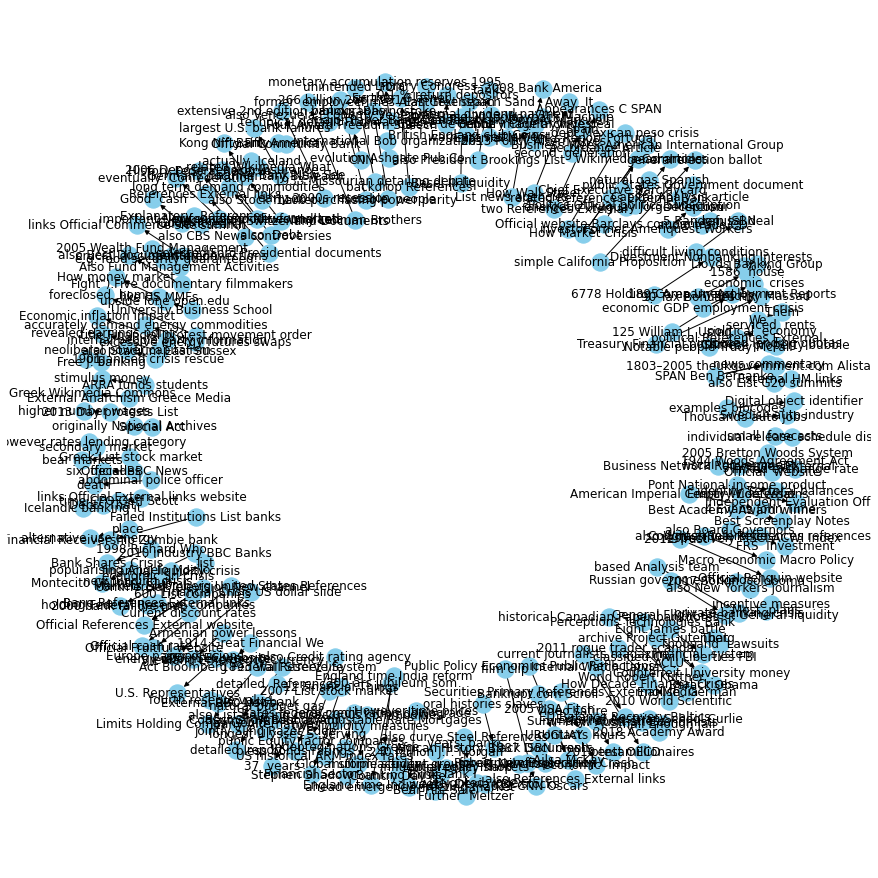

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “Instrastructure”:

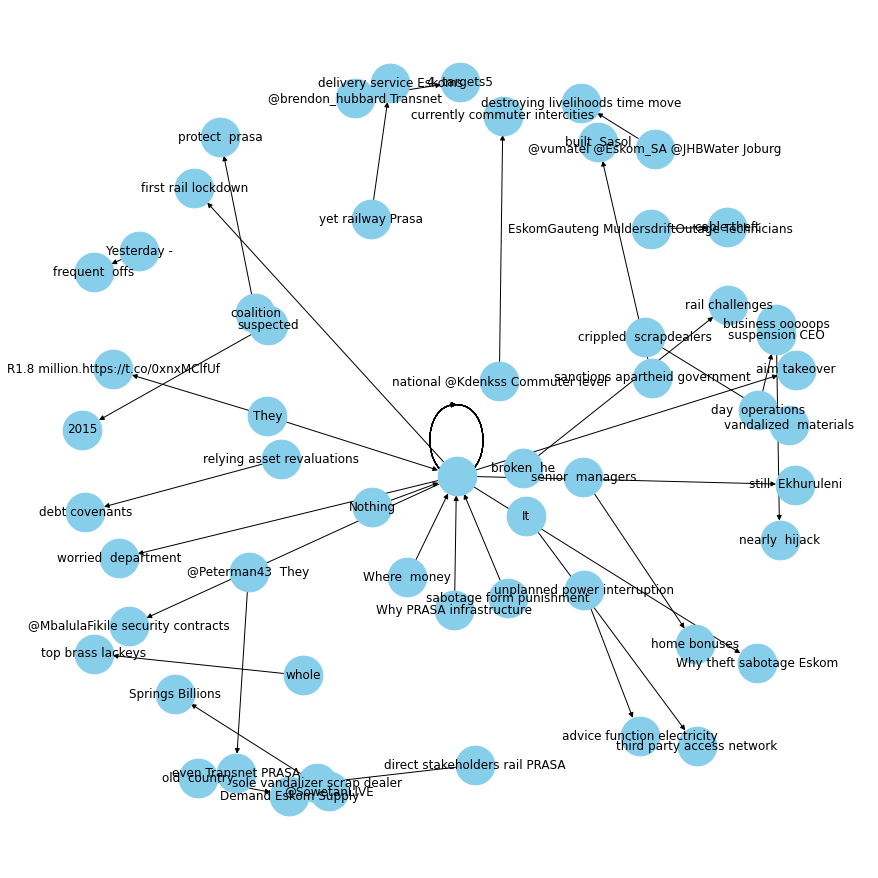

In [27]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="infrastructure"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

The relation “Vandalism”:

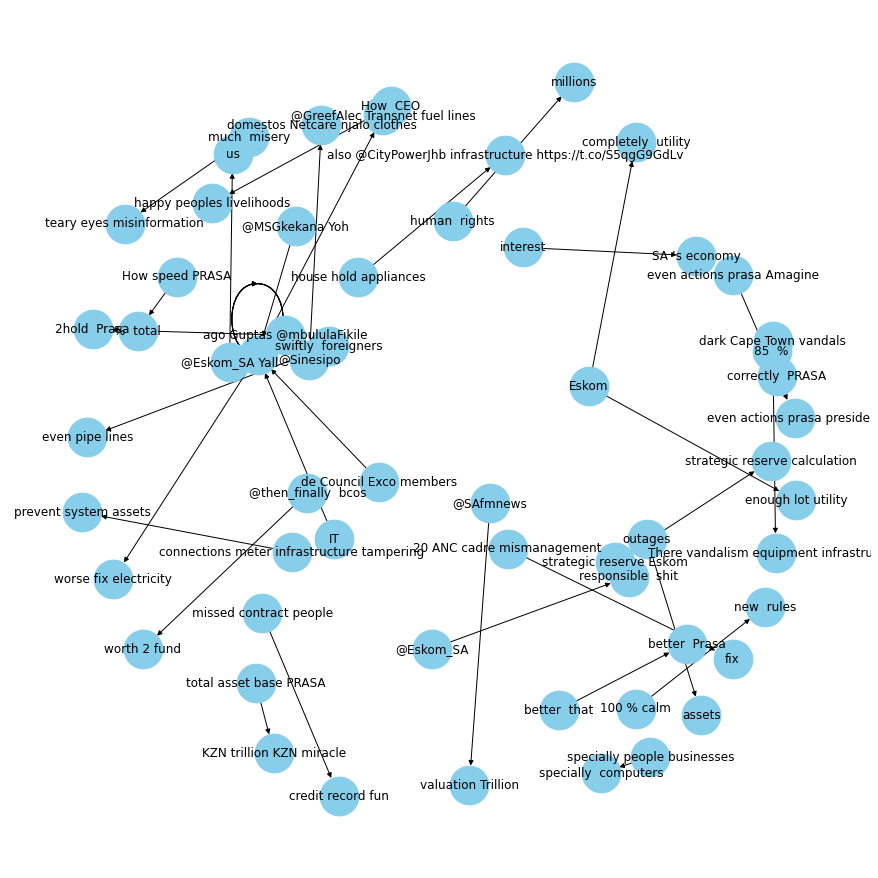

In [37]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="damage"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the vandalism of infrastructure. For instance, dark Cape Town vandals 85%, has entities like “There vandalism equipment Infrastructure” connected to it in the graph above.

Let’s check out a few more relations.

Now I would like to visualize the graph for the “Theft” relation:

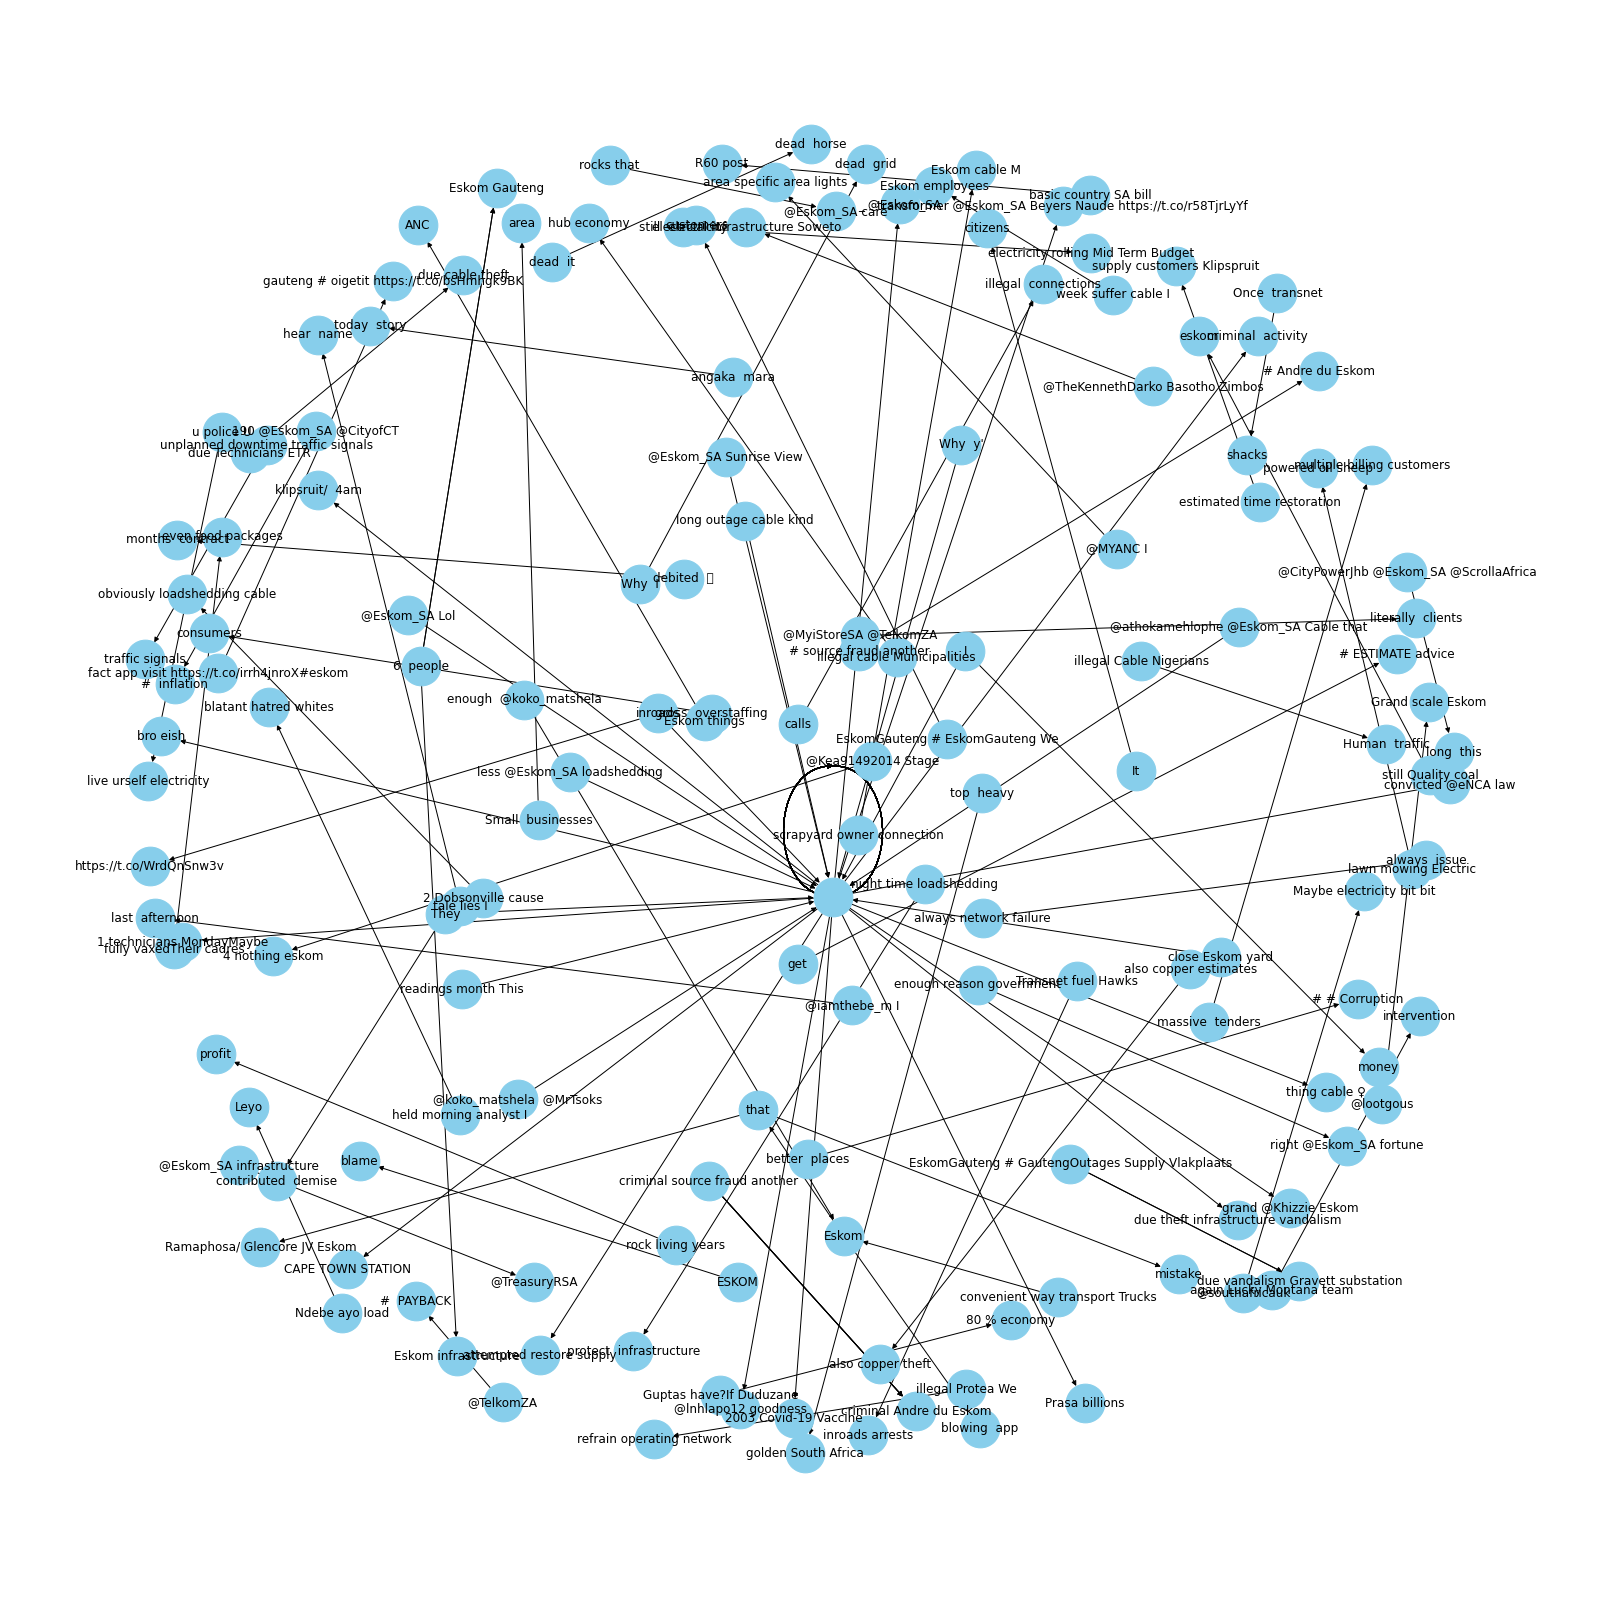

In [41]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="theft"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(22,22))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

The graph for the “cable” relation:

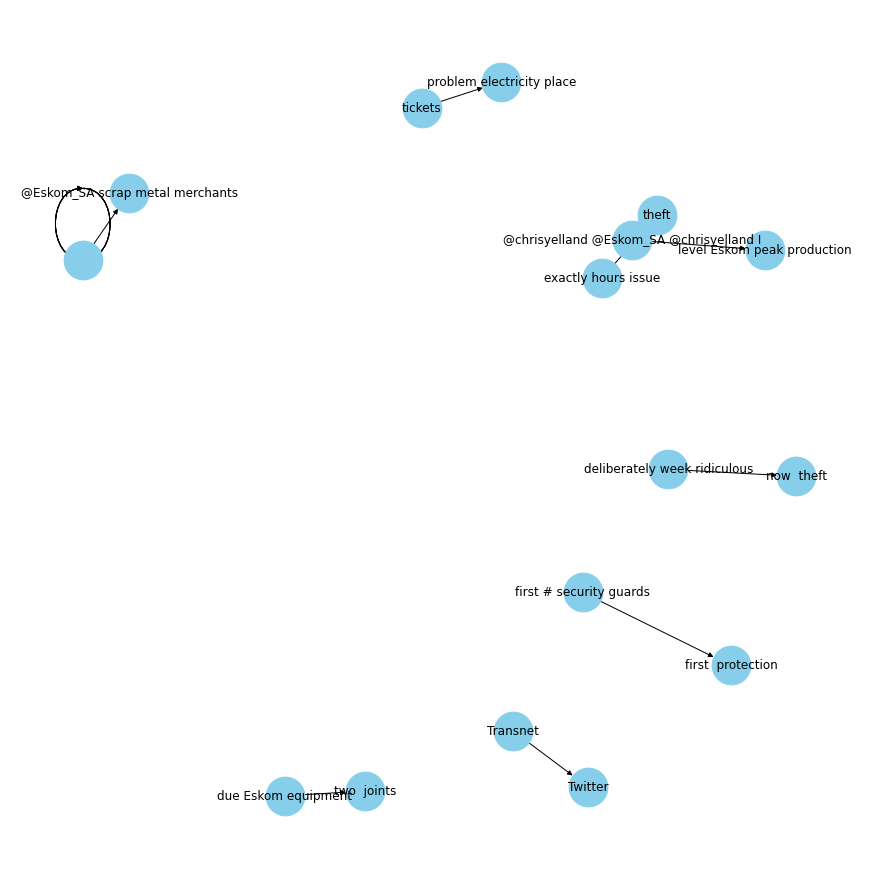

In [38]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="cable"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()